In [1]:
'''
Steps to initialize project and install dependencies:

# sudo pip3 install pyyaml ipython jupyter ipyparallel pandas boto -U

# export PYSPARK_DRIVER_PYTHON=/usr/local/bin/jupyter
# export PYSPARK_DRIVER_PYTHON_OPTS="notebook --no-browser  --ip=0.0.0.0 --port=8888"
# source ~/.bashrc

# python -m pip install --user --upgrade pip
# pip3 install geopandas
# pip3 install descartes

'''

'\nSteps to initialize project and install dependencies:\n\n# sudo pip3 install pyyaml ipython jupyter ipyparallel pandas boto -U\n\n# export PYSPARK_DRIVER_PYTHON=/usr/local/bin/jupyter\n# export PYSPARK_DRIVER_PYTHON_OPTS="notebook --no-browser  --ip=0.0.0.0 --port=8888"\n# source ~/.bashrc\n\n# python -m pip install --user --upgrade pip\n# pip3 install geopandas\n# pip3 install descartes\n\n'

In [2]:
import re # using regular expression to find different seperators
from pyspark.sql.types import *
from pyspark.sql.functions import * # importing col

In [3]:
# getting data from s3

device_status ='s3://dsci2020finalproject/devicestatus.txt'
lat_longs ='s3://dsci2020finalproject/lat_longs.txt'
sample_geo ='s3://dsci2020finalproject/sample_geo.txt'

In [4]:
device_status_log=sc.textFile(device_status)

# using regular expression to find the seperator
temp_var = device_status_log.map(lambda k: re.split('[,|_/]', k)) 

# Load data into dataframe and change the column names and select required data only
device_status_df = temp_var.toDF().select(col("_13").alias("latitude"), col("_14").alias("longitude"), col("_1").alias("Date"), col("_2").alias("Model"), col("_3").alias("Device ID"))

# device_status_df = device_status_df.withColumn("date", unix_timestamp(device_status_df["date"], "yyyy-mm-dd:HH:mm:ss").cast('timestamp'))
device_status_df = device_status_df.withColumn("Latitude", device_status_df["latitude"].cast('double'))
device_status_df = device_status_df.withColumn("Longitude", device_status_df["longitude"].cast('double'))

# filter latitude and longitude with 0 values
device_status_df = device_status_df.filter("Latitude != '0' or Longitude != '0' ")

# need to re look
# split model into manufacturer and model column
device_status_df = device_status_df.withColumn("Manufacturer", split(col("Model"), " ").getItem(0)).withColumn("Model", split(col("Model"), " ").getItem(1))

#caching df 
device_status_df.cache()

device_status_df.show(5)

+-------------+--------------+-------------------+-------+--------------------+------------+
|     Latitude|     Longitude|               Date|  Model|           Device ID|Manufacturer|
+-------------+--------------+-------------------+-------+--------------------+------------+
|33.6894754264|-117.543308253|2014-03-15:10:10:20|   F41L|8cc3b47e-bd01-448...|    Sorrento|
|37.4321088904|-121.485029632|2014-03-15:10:10:20|    1.0|ef8c7564-0a1a-465...|      MeeToo|
|39.4378908349|-120.938978486|2014-03-15:10:10:20|    1.0|23eba027-b95a-472...|      MeeToo|
|39.3635186767|-119.400334708|2014-03-15:10:10:20|   F41L|707daba1-5640-4d6...|    Sorrento|
|33.1913581092|-116.448242643|2014-03-15:10:10:20|Novelty|db66fe81-aa55-43b...|       Ronin|
+-------------+--------------+-------------------+-------+--------------------+------------+
only showing top 5 rows



In [5]:
# write df to s3 
device_status_df.coalesce(1).write.mode("overwrite").option("sep", ",").option("header","true").option("encoding", "UTF-8").csv("s3a://dsci2020finalproject/updated_device_status")

In [6]:
# Loading sample geo data

sample_geo_log=sc.textFile(sample_geo)
header = sample_geo_log.first()

sample_geo_log = sample_geo_log.filter(lambda line: line != header)

temp_var1 = sample_geo_log.map(lambda k:k.split('\t'))
temp_var1 = temp_var1.filter(lambda line: line != [''])

sample_geo_log_df=temp_var1.toDF(header.split("\t"))

sample_geo_log_df = sample_geo_log_df.withColumn("Latitude", sample_geo_log_df["Latitude"].cast('double'))
sample_geo_log_df = sample_geo_log_df.withColumn("Longitude", sample_geo_log_df["Longitude"].cast('double'))

#caching df 
sample_geo_log_df.cache()
sample_geo_log_df.show(5)

+-----------+------------+----------+
|   Latitude|   Longitude|LocationID|
+-----------+------------+----------+
|37.77253945|-77.49954987|         1|
|42.09013298|-87.68915558|         2|
|39.56341754|-75.58753204|         3|
|39.45302347|-87.69374084|         4|
| 38.9537989|-77.01656342|         5|
+-----------+------------+----------+
only showing top 5 rows



In [7]:
# Loading lat_longs data
lat_longs_log=sc.textFile(lat_longs)

temp_var2 = lat_longs_log.map(lambda k:k.split())

long_lats_log_df = temp_var2.toDF().select(col("_1").alias("Latitude"), col("_2").alias("Longitude"), col("_3").alias("Url"))

long_lats_log_df = long_lats_log_df.withColumn("Latitude", long_lats_log_df["Latitude"].cast('double'))
long_lats_log_df = long_lats_log_df.withColumn("Longitude", long_lats_log_df["Longitude"].cast('double'))

#caching df
long_lats_log_df.cache()

long_lats_log_df.show(5)

+------------------+------------------+--------------------+
|          Latitude|         Longitude|                 Url|
+------------------+------------------+--------------------+
|              36.7| 3.216666666666667|<http://dbpedia.o...|
|              42.5|1.5166666666666666|<http://dbpedia.o...|
|12.516666666666667|-70.03333333333333|<http://dbpedia.o...|
|-8.833333333333334|13.333333333333334|<http://dbpedia.o...|
|41.333333333333336|              19.8|<http://dbpedia.o...|
+------------------+------------------+--------------------+
only showing top 5 rows



In [8]:
# plot longitude and latitude to world map using geopandas

import pandas as pd
import geopandas
import matplotlib.pyplot as plt

def plot_data(df, a=0, after_prediction=False):
    pd_df = df.toPandas() # changing df to pandas dataframe
    gdf = geopandas.GeoDataFrame(pd_df, geometry=geopandas.points_from_xy(pd_df.Longitude, pd_df.Latitude))
    
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    if a == 1:
        ax = world.plot(figsize=(20, 12), edgecolor='black', cmap='GnBu')
    else:
        ax = world[world.name == 'United States of America'].plot(figsize=(10, 6), cmap='twilight', edgecolor='black')

    if after_prediction == False:
        gdf.plot(ax=ax, marker='.', color='red', markersize=15)
    else:
        gdf.plot(ax=ax, column='prediction',marker='.', markersize=15, categorical=True, legend=True)
        plt.scatter(centers.iloc[:,1],centers.iloc[:,0], marker="^", s=80, color='black')

    plt.show()

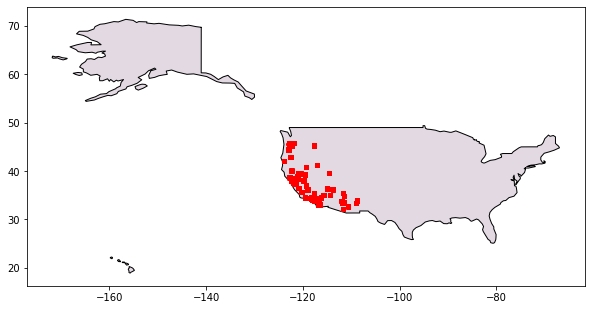

In [9]:
# PLOT DEVICE STATUS DATA
plot_data(device_status_df, a=0)


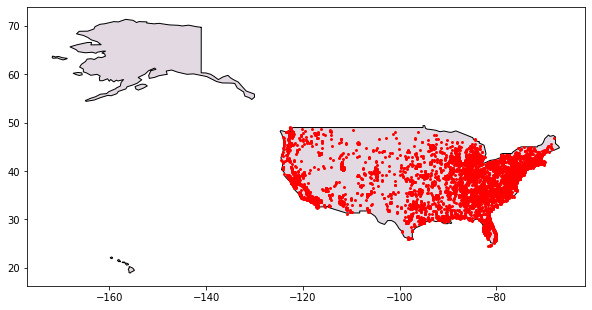

In [10]:
# PLOT SAMPLE GEO DATA
plot_data(sample_geo_log_df, a=0)


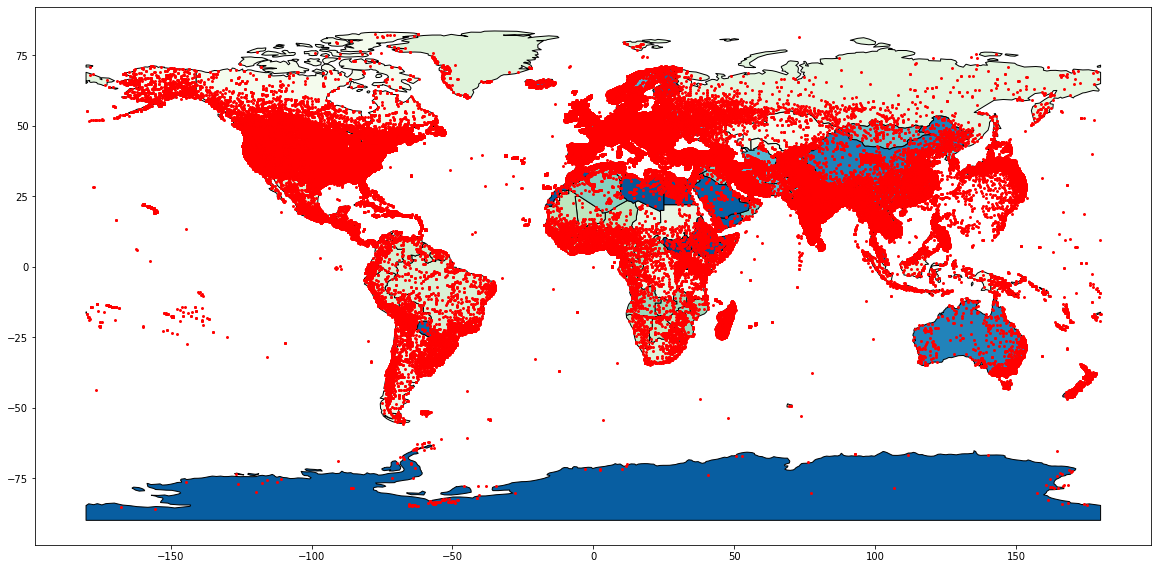

In [11]:
# PLOT LatLong DATA
plot_data(long_lats_log_df, a=1)

In [12]:
# Step 2: Implementing k-means

import numpy as np
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


In [13]:
# to convert lon lat to vector for kmeans computation

def converting_lat_log_using_vectorAssembler(df):
    vecAssembler = VectorAssembler(inputCols=["Latitude", "Longitude"], outputCol="features")
    new_df = vecAssembler.transform(df)
#     print(new_df.show(3))
    return new_df

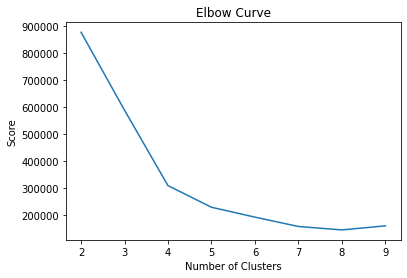

In [14]:
# Calculate cost and plot to find the right cluster
cost = np.zeros(10)

new_device_status_df = converting_lat_log_using_vectorAssembler(device_status_df)

for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(new_device_status_df)
    cost[k] = model.summary.trainingCost

# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8,9]
df_cost.insert(0, 'cluster', new_col)

plt.plot(df_cost.cluster, df_cost.cost)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [15]:
# from the curve we find the 4,5,6 could be the perfect cluster

In [16]:
# function to calculate kmean, transform df, euclidean distance, sum of sq errors and center

def kmeans_model(df, k, seed ):
    # Trains a k-means model.
    new_df_with_vector = converting_lat_log_using_vectorAssembler(df)
    
    kmeans = KMeans().setK(k).setSeed(seed)
    model = kmeans.fit(new_df_with_vector)

    # Make predictions
    predictions = model.transform(new_df_with_vector)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)
    print("Silhouette with squared euclidean distance = " + str(silhouette))


    # Evaluate clustering.
    cost = model.computeCost(new_df_with_vector)
    print("Within Set Sum of Squared Errors = " + str(cost))

    # Shows the result.
    print("Cluster Centers: ")
    ctr=[]
    centers = model.clusterCenters()
    for center in centers:
        ctr.append(center)
        print(center)

    centers = pd.DataFrame(ctr)
    
    return predictions, centers

In [24]:
# Calculate for DEVICE STATUS DATAFRAMEs

%time prediction_df, centers = kmeans_model(df=device_status_df, k=4, seed=1)

Silhouette with squared euclidean distance = 0.7540828544162818
Within Set Sum of Squared Errors = 309322.4486914122
Cluster Centers: 
[  34.30404014 -117.8032879 ]
[  44.23926087 -121.79580631]
[  38.19538776 -121.08051278]
[  35.08461054 -112.57140921]
CPU times: user 39.1 ms, sys: 3.87 ms, total: 43 ms
Wall time: 2.27 s


In [26]:
prediction_df.show()

+-------------+--------------+-------------------+-------+--------------------+------------+--------------------+----------+
|     Latitude|     Longitude|               Date|  Model|           Device ID|Manufacturer|            features|prediction|
+-------------+--------------+-------------------+-------+--------------------+------------+--------------------+----------+
|33.6894754264|-117.543308253|2014-03-15:10:10:20|   F41L|8cc3b47e-bd01-448...|    Sorrento|[33.6894754264,-1...|         0|
|37.4321088904|-121.485029632|2014-03-15:10:10:20|    1.0|ef8c7564-0a1a-465...|      MeeToo|[37.4321088904,-1...|         2|
|39.4378908349|-120.938978486|2014-03-15:10:10:20|    1.0|23eba027-b95a-472...|      MeeToo|[39.4378908349,-1...|         2|
|39.3635186767|-119.400334708|2014-03-15:10:10:20|   F41L|707daba1-5640-4d6...|    Sorrento|[39.3635186767,-1...|         2|
|33.1913581092|-116.448242643|2014-03-15:10:10:20|Novelty|db66fe81-aa55-43b...|       Ronin|[33.1913581092,-1...|         0|


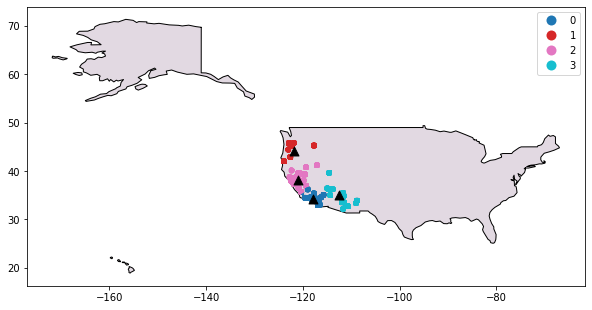

CPU times: user 10.9 s, sys: 180 ms, total: 11.1 s
Wall time: 11.3 s


In [18]:
%time plot_data(prediction_df, a=0, after_prediction=True)

Silhouette with squared euclidean distance = 0.7911724452946861
Within Set Sum of Squared Errors = 229329.08140511927
Cluster Centers: 
[  34.29368632 -117.81213281]
[  44.23926087 -121.79580631]
[  37.33148137 -114.84963868]
[  38.0957093  -121.19758985]
[  33.68736796 -111.04079699]
CPU times: user 30.4 ms, sys: 12.4 ms, total: 42.8 ms
Wall time: 3.24 s


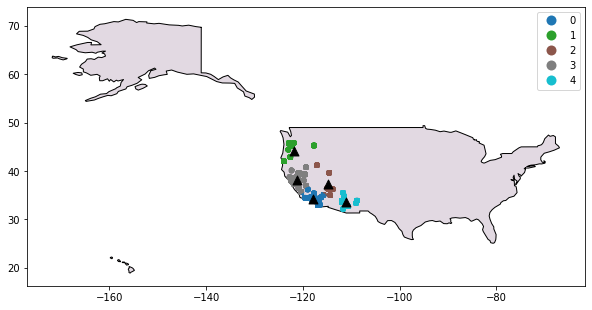

CPU times: user 11.4 s, sys: 224 ms, total: 11.6 s
Wall time: 11.6 s


In [19]:
# Step 3: Compute and Visualize Clusters

# Calculate the k-means clusters for the device location data using k = 5.

%time prediction_df, centers = kmeans_model(df=device_status_df, k=5, seed=1)

%time plot_data(prediction_df, a=0, after_prediction=True)


Calculating the k-means clusters for the synthetic location data using k = 2
Silhouette with squared euclidean distance = 0.8525189358156998
Within Set Sum of Squared Errors = 704244.7373775935
Cluster Centers: 
[ 37.5647472  -82.55711082]
[  38.07161548 -116.43342043]
CPU times: user 43.9 ms, sys: 4.21 ms, total: 48.1 ms
Wall time: 2.02 s


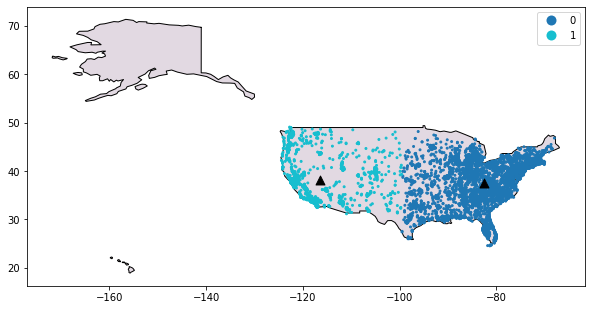

CPU times: user 2.35 s, sys: 95.8 ms, total: 2.45 s
Wall time: 2.77 s


In [20]:
# Calculate the k-means clusters for the synthetic location data using k = 2 and k = 4.

print("Calculating the k-means clusters for the synthetic location data using k = 2")

# calculate for sample geo data
%time prediction_df, centers = kmeans_model(df=sample_geo_log_df, k=2, seed=1)

%time plot_data(prediction_df, a=0, after_prediction=True)


Calculating the k-means clusters for the synthetic location data using k = 4
Silhouette with squared euclidean distance = 0.5548689033882502
Within Set Sum of Squared Errors = 365558.3934312812
Cluster Centers: 
[ 40.14836238 -76.96598964]
[  35.57495009 -113.07189577]
[  41.49405835 -121.33793416]
[ 35.11449774 -87.93102449]
CPU times: user 107 ms, sys: 7.64 ms, total: 115 ms
Wall time: 2.19 s


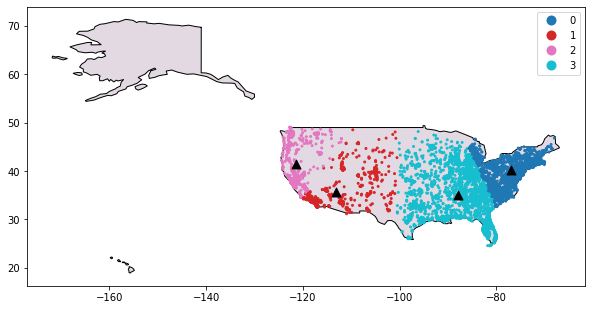

CPU times: user 1.5 s, sys: 153 ms, total: 1.65 s
Wall time: 1.47 s


In [21]:
print("Calculating the k-means clusters for the synthetic location data using k = 4")

%time prediction_df, centers = kmeans_model(df=sample_geo_log_df, k=4, seed=1)

%time plot_data(prediction_df, a=0, after_prediction=True)


Calculating the k-means clusters for the synthetic location data using k = 5
Silhouette with squared euclidean distance = 0.579380126122293
Within Set Sum of Squared Errors = 276292.5761643455
Cluster Centers: 
[ 38.03380474 -82.91911996]
[  38.08274514 -116.98428691]
[ 40.689765   -74.77185746]
[ 40.76409505 -91.99226496]
[ 30.22653902 -88.43888705]
CPU times: user 91.1 ms, sys: 663 µs, total: 91.8 ms
Wall time: 2.2 s


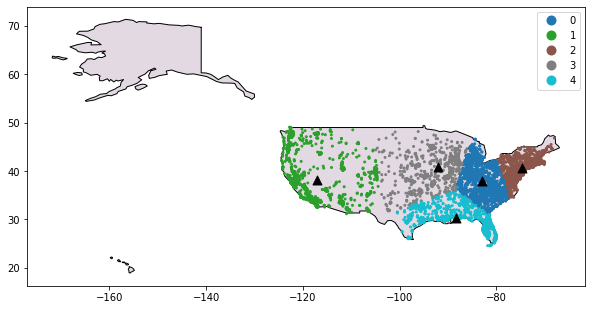

CPU times: user 1.43 s, sys: 140 ms, total: 1.57 s
Wall time: 1.4 s


In [22]:
print("Calculating the k-means clusters for the synthetic location data using k = 5")

%time prediction_df, centers = kmeans_model(df=sample_geo_log_df, k=5, seed=1)

%time plot_data(prediction_df, a=0, after_prediction=True)


Calculating the k-means clusters for the synthetic location data using k = 6
Silhouette with squared euclidean distance = 0.7199107240404778
Within Set Sum of Squared Errors = 121593903.3697077
Cluster Centers: 
[48.59554363  9.7731195 ]
[22.591739   83.18051205]
[  42.38381357 -116.64759113]
[ 17.2112931  134.06313631]
[30.47517672 48.12423989]
[ 34.19284121 -81.42496763]
CPU times: user 78 ms, sys: 4.62 ms, total: 82.6 ms
Wall time: 9.02 s


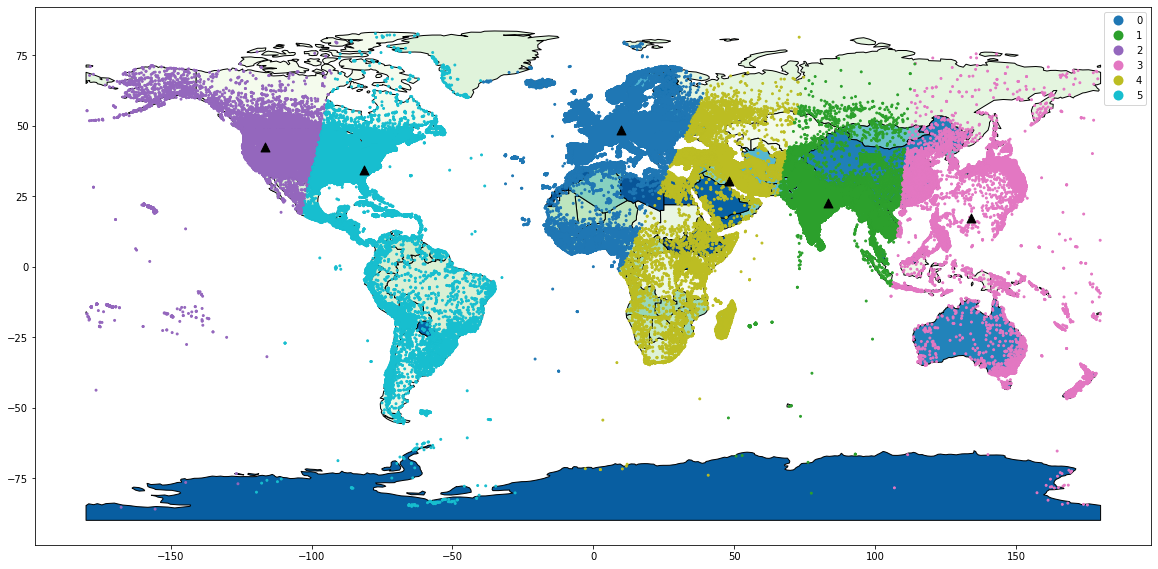

CPU times: user 54.7 s, sys: 639 ms, total: 55.3 s
Wall time: 55.9 s


In [23]:
# Calculate the k-means clusters for the large-scale DBpedia location data. use k = 6 

print("Calculating the k-means clusters for the synthetic location data using k = 6")
# calculate for long lat data
%time prediction_df, centers = kmeans_model(df=long_lats_log_df, k=6, seed=1)

%time plot_data(prediction_df, a=1, after_prediction=True)
